**Name:** Alexandros Kazos

**Title:** Crime Data Star Schema and Reports with PySpark\
**Description:** This notebook demonstrates how to transform raw crime data into a star schema using PySpark,

## Imports

In [1]:
import os
from pyspark.sql import SparkSession, functions as F

## Spark Session

In [2]:
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("CrimeStarSchema")
    .getOrCreate()
)

## Load Data

In [3]:
input_path = os.path.join("..", "Data", "Input", "CrimeData.csv")
output_base = os.path.join("..", "Data", "Output")

In [4]:
# Read raw CSV (semicolon separator)
raw = spark.read.option("header", True).option("sep", ";").option("inferSchema", True).csv(input_path)

In [5]:
raw

DataFrame[CaseID: int, DateOccured: date, AreaCode: int, Area: string, CrimeCode: int, CrimeDescription: string, VictimAge: int, VictimSex: string, VictimDescentCode: string, VictimDescent: string, PremisCode: int, PremisDescription: string, WeaponCode: int, Weapon: string, CaseStatusCode: string, CaseStatusDescription: string, latitude: double, longitude: double]

In [6]:
# Normalize dates and add DateKey (yyyymmdd int)
raw = (
    raw.withColumn("Date", F.to_date(F.col("DateOccured")))
         .withColumn("DateKey", F.date_format(F.col("Date"), "yyyyMMdd").cast("int"))
)

In [7]:
raw.show(5)

+---------+-----------+--------+-----------+---------+--------------------+---------+---------+-----------------+--------------------+----------+--------------------+----------+--------------------+--------------+---------------------+--------+---------+----------+--------+
|   CaseID|DateOccured|AreaCode|       Area|CrimeCode|    CrimeDescription|VictimAge|VictimSex|VictimDescentCode|       VictimDescent|PremisCode|   PremisDescription|WeaponCode|              Weapon|CaseStatusCode|CaseStatusDescription|latitude|longitude|      Date| DateKey|
+---------+-----------+--------+-----------+---------+--------------------+---------+---------+-----------------+--------------------+----------+--------------------+----------+--------------------+--------------+---------------------+--------+---------+----------+--------+
|191501505| 2020-01-01|      15|N Hollywood|      745|VANDALISM - MISDE...|       76|        F|                W|              White |       502|MULTI-UNIT DWELLI...|         

---
## Dimensions and Fact Tables

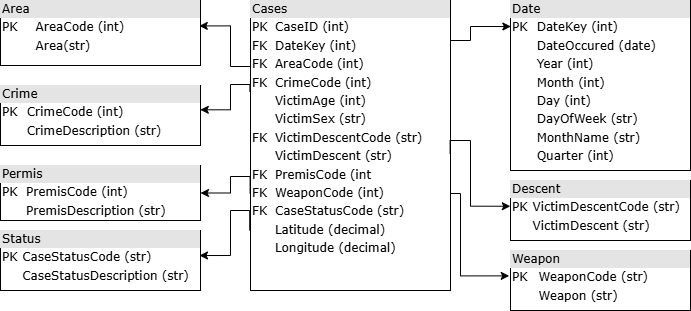

_Note: for more information regarding the proposed star schema please refer to the check_raw_data notebook._

## Dimensions

#### 1) Date dimension

In [8]:
date_df = (
    raw.select("Date", "DateKey").dropDuplicates()
        .withColumn("Year", F.year("Date"))
        .withColumn("Month", F.month("Date"))
        .withColumn("Day", F.dayofmonth("Date"))
        .withColumn("DayOfWeek", F.date_format("Date", "EEEE"))
        .withColumn("MonthName", F.date_format("Date", "MMMM"))
        .withColumn("Quarter", F.quarter("Date"))
        .orderBy("DateKey")
)

In [9]:
date_df.show(5)

+----------+--------+----+-----+---+---------+---------+-------+
|      Date| DateKey|Year|Month|Day|DayOfWeek|MonthName|Quarter|
+----------+--------+----+-----+---+---------+---------+-------+
|2020-01-01|20200101|2020|    1|  1|Wednesday|  January|      1|
|2020-01-02|20200102|2020|    1|  2| Thursday|  January|      1|
|2020-01-03|20200103|2020|    1|  3|   Friday|  January|      1|
|2020-01-04|20200104|2020|    1|  4| Saturday|  January|      1|
|2020-01-05|20200105|2020|    1|  5|   Sunday|  January|      1|
+----------+--------+----+-----+---+---------+---------+-------+
only showing top 5 rows


#### 2) Area dimension

In [10]:
area_df = raw.select("AreaCode", "Area").dropDuplicates().orderBy("AreaCode")

In [11]:
area_df.show(5)

+--------+----------+
|AreaCode|      Area|
+--------+----------+
|       1|   Central|
|       2|   Rampart|
|       3| Southwest|
|       4|Hollenbeck|
|       5|    Harbor|
+--------+----------+
only showing top 5 rows


#### 3) Crime dimension

In [13]:
crime_df = raw.select("CrimeCode", "CrimeDescription").dropDuplicates().orderBy("CrimeCode")

In [14]:
crime_df.show(5)

+---------+--------------------+
|CrimeCode|    CrimeDescription|
+---------+--------------------+
|      110|   CRIMINAL HOMICIDE|
|      113|MANSLAUGHTER, NEG...|
|      121|      RAPE, FORCIBLE|
|      122|     RAPE, ATTEMPTED|
|      210|             ROBBERY|
+---------+--------------------+
only showing top 5 rows


#### 4) Premis dimension

In [15]:
premis_df = raw.select("PremisCode", "PremisDescription").dropDuplicates().orderBy("PremisCode")

In [16]:
premis_df.show(5)

+----------+--------------------+
|PremisCode|   PremisDescription|
+----------+--------------------+
|       101|              STREET|
|       102|            SIDEWALK|
|       103|               ALLEY|
|       104|            DRIVEWAY|
|       105|PEDESTRIAN OVERCR...|
+----------+--------------------+
only showing top 5 rows


#### 5) Status dimension

In [17]:
status_df = raw.select("CaseStatusCode", "CaseStatusDescription").dropDuplicates().orderBy("CaseStatusCode")

In [18]:
status_df.show(5)

+--------------+---------------------+
|CaseStatusCode|CaseStatusDescription|
+--------------+---------------------+
|            AA|         Adult Arrest|
|            AO|          Adult Other|
|            CC|                  UNK|
|            IC|          Invest Cont|
|            JA|           Juv Arrest|
+--------------+---------------------+
only showing top 5 rows


#### 6) Weapon dimension

In [19]:
weapon_df = raw.select("WeaponCode", "Weapon").dropDuplicates().orderBy("WeaponCode")

In [20]:
weapon_df.show(5)

+----------+--------+
|WeaponCode|  Weapon|
+----------+--------+
|         0| UNKNOWN|
|       101|REVOLVER|
|       102|HAND GUN|
|       103|   RIFLE|
|       104| SHOTGUN|
+----------+--------+
only showing top 5 rows


#### 7) Descent dimension

In [21]:
descent_df = raw.select("VictimDescentCode", "VictimDescent").dropDuplicates().orderBy("VictimDescentCode")

In [22]:
descent_df.show(5)

+-----------------+-------------+
|VictimDescentCode|VictimDescent|
+-----------------+-------------+
|                A|  Other Asian|
|                B|        Black|
|                C|      Chinese|
|                D|    Cambodian|
|                F|     Filipino|
+-----------------+-------------+
only showing top 5 rows


---
### Fact table
Cases (keep CaseID + foreign keys + attributes)

In [23]:
cases_df = raw.select(
    "CaseID",
    "DateKey",
    "AreaCode",
    "CrimeCode",
    "VictimAge",
    "VictimSex",
    "VictimDescentCode",
    "PremisCode",
    "WeaponCode",
    "CaseStatusCode",
    "latitude",
    "longitude"
)

In [24]:
cases_df.show(5)

+---------+--------+--------+---------+---------+---------+-----------------+----------+----------+--------------+--------+---------+
|   CaseID| DateKey|AreaCode|CrimeCode|VictimAge|VictimSex|VictimDescentCode|PremisCode|WeaponCode|CaseStatusCode|latitude|longitude|
+---------+--------+--------+---------+---------+---------+-----------------+----------+----------+--------------+--------+---------+
|191501505|20200101|      15|      745|       76|        F|                W|       502|         0|            IC| 34.1685|-118.4019|
|191921269|20200101|      19|      740|       31|        X|                X|       409|         0|            IC| 34.2198|-118.4468|
|200100501|20200101|       1|      121|       25|        F|                H|       735|       500|            IC| 34.0452|-118.2534|
|200100502|20200102|       1|      442|       23|        M|                H|       404|         0|            IC| 34.0483|-118.2631|
|200100504|20200104|       1|      946|        0|        X|   

### Register as tables as views

In [25]:
date_df.createOrReplaceTempView("dim_date")
area_df.createOrReplaceTempView("dim_area")
crime_df.createOrReplaceTempView("dim_crime")
premis_df.createOrReplaceTempView("dim_premis")
status_df.createOrReplaceTempView("dim_status")
weapon_df.createOrReplaceTempView("dim_weapon")
descent_df.createOrReplaceTempView("dim_descent")
cases_df.createOrReplaceTempView("fact_cases")

### Save as Parquet

In [18]:
# Write dimensions and fact to Parquet
tables = {
    "dim_date": date_df,
    "dim_area": area_df,
    "dim_crime": crime_df,
    "dim_premis": premis_df,
    "dim_status": status_df,
    "dim_weapon": weapon_df,
    "dim_descent": descent_df,
    "fact_cases": cases_df
}

for name, df in tables.items():
    out_path = os.path.join(output_base, name)
    df.write.mode("overwrite").parquet(out_path)

---

## Reports

### Incidents per Area and Premis Type

In [26]:
case_per_area_premis_df = (
    cases_df.alias("f")
        .join(area_df.alias("a"), F.col("f.AreaCode") == F.col("a.AreaCode"), "left")
        .join(premis_df.alias("p"), F.col("f.PremisCode") == F.col("p.PremisCode"), "left")
        .groupBy("a.Area", "p.PremisDescription")
        .agg(F.count("*").alias("Αριθμός_Περιστατικών"))
        .select(F.col("Area"), F.col("PremisDescription").alias("Τύπος"), F.col("Αριθμός_Περιστατικών"))
        .orderBy(F.asc("Area"), F.desc("Αριθμός_Περιστατικών"))
)

In [27]:
case_per_area_premis_df.show(5)

+-----------+--------------------+--------------------+
|       Area|               Τύπος|Αριθμός_Περιστατικών|
+-----------+--------------------+--------------------+
|77th Street|SINGLE FAMILY DWE...|                5635|
|77th Street|              STREET|                3659|
|77th Street|MULTI-UNIT DWELLI...|                1633|
|77th Street|            SIDEWALK|                 785|
|77th Street|VEHICLE, PASSENGE...|                 577|
+-----------+--------------------+--------------------+
only showing top 5 rows


### Top 10 Crimes

In [28]:
top10_crimes = (
    cases_df.alias("f")
        .join(crime_df.alias("c"), F.col("f.CrimeCode") == F.col("c.CrimeCode"), "left")
        .groupBy("c.CrimeDescription")
        .agg(F.count("*").alias("Αριθμός_Περιστατικών"))
        .select(
            F.col("CrimeDescription").alias("Είδος_Εγκλήματος"),
            F.col("Αριθμός_Περιστατικών")
        )
        .orderBy(F.desc("Αριθμός_Περιστατικών"))
        .limit(10)
)


In [29]:
top10_crimes.show(5)

+--------------------+--------------------+
|    Είδος_Εγκλήματος|Αριθμός_Περιστατικών|
+--------------------+--------------------+
|   THEFT OF IDENTITY|               26647|
|BATTERY - SIMPLE ...|               21760|
|VANDALISM - FELON...|               16554|
|BURGLARY FROM VEH...|               16355|
|            BURGLARY|               16256|
+--------------------+--------------------+
only showing top 5 rows


### Monthly Incident Count by Year

In [30]:
cases_per_year = (
    cases_df.alias("f")
        .join(date_df.alias("d"), F.col("f.DateKey") == F.col("d.DateKey"), "left")
        .groupBy("d.Year", "d.Month")
        .agg(F.count("*").alias("Αριθμός_Περιστατικών"))
        .orderBy(F.asc("Year"), F.asc("Month"))
)

In [31]:
cases_per_year.show(5)

+----+-----+--------------------+
|Year|Month|Αριθμός_Περιστατικών|
+----+-----+--------------------+
|2020|    1|                5326|
|2020|    2|                5252|
|2020|    3|                4963|
|2020|    4|                4146|
|2020|    5|                4454|
+----+-----+--------------------+
only showing top 5 rows


### Incident Status by Crime Type

In [32]:
crime_cases_status = (
    cases_df.alias("f")
        .join(crime_df.alias("c"), F.col("f.CrimeCode") == F.col("c.CrimeCode"), "left")
        .join(status_df.alias("s"), F.col("f.CaseStatusCode") == F.col("s.CaseStatusCode"), "left")
        .groupBy("c.CrimeDescription", "s.CaseStatusDescription")
        .agg(F.count("*").alias("Αριθμός_Περιστατικών"))
        .select(
            F.col("CrimeDescription").alias("Είδος_Εγκλήματος"),
            F.col("CaseStatusDescription").alias("Κατάσταση_Περιστατικού"),
            F.col("Αριθμός_Περιστατικών")
        )
        .orderBy(F.asc("Είδος_Εγκλήματος"), F.asc("Κατάσταση_Περιστατικού"))
)

In [33]:
crime_cases_status.show(5)

+--------------------+----------------------+--------------------+
|    Είδος_Εγκλήματος|Κατάσταση_Περιστατικού|Αριθμός_Περιστατικών|
+--------------------+----------------------+--------------------+
|               ARSON|          Adult Arrest|                  64|
|               ARSON|           Adult Other|                  14|
|               ARSON|           Invest Cont|                 658|
|ASSAULT WITH DEAD...|          Adult Arrest|                 170|
|ASSAULT WITH DEAD...|           Adult Other|                  39|
+--------------------+----------------------+--------------------+
only showing top 5 rows


### Data Cube (Victim Descent, Sex, Age)

In [35]:
victim_sex_age = (
    cases_df.alias("f")
        .join(descent_df.alias("d"), F.col("f.VictimDescentCode") == F.col("d.VictimDescentCode"), "left")
        .rollup("d.VictimDescent", "f.VictimSex", "f.VictimAge")
        .agg(F.count("*").alias("Αριθμός_Περιστατικών"))
        .na.fill("TOTAL")
        .select(
            F.coalesce(F.col("VictimDescent"), F.lit("Total Descent")).alias("Χώρα_Καταγωγής"),
            F.coalesce(F.col("VictimSex"), F.lit("Total Sex")).alias("Φύλο"),
            F.coalesce(F.col("VictimAge").cast("string"), F.lit("Total Age")).alias("Ηλικία"),
            F.col("Αριθμός_Περιστατικών")
        )
        .orderBy(F.asc("Χώρα_Καταγωγής"), F.asc("Φύλο"), F.asc("Ηλικία"))
)

In [36]:
victim_sex_age.show(5)

+---------------+----+------+--------------------+
| Χώρα_Καταγωγής|Φύλο|Ηλικία|Αριθμός_Περιστατικών|
+---------------+----+------+--------------------+
|American Indian|   F|     0|                   1|
|American Indian|   F|    19|                   3|
|American Indian|   F|    20|                   2|
|American Indian|   F|    21|                   2|
|American Indian|   F|    22|                   6|
+---------------+----+------+--------------------+
only showing top 5 rows


## Save Reports

In [37]:
# Save Reports
reports = {
    "case_per_area_premis_df": case_per_area_premis_df,
    "top10_crimes": top10_crimes,
    "cases_per_year": cases_per_year,
    "crime_cases_status": crime_cases_status,
    "victim_sex_age": victim_sex_age
}

for name, df in reports.items():
    # Save each report to a single CSV file
    df.coalesce(1).write.csv(os.path.join(output_base, "reports", name), mode="overwrite", header=True)
    print(f"Saved report: {name}")

Saved report: case_per_area_premis_df
Saved report: top10_crimes
Saved report: cases_per_year
Saved report: crime_cases_status
Saved report: victim_sex_age


In [38]:
spark.stop()